## Importing Required libraries

In [4]:
!pip install -U --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [5]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [6]:
tf.__version__

'2.1.0-rc0'

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Data Visualisation

In [8]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [9]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [10]:
pwd


'/kaggle/working'

In [11]:
meta.shape

(95634, 5)

In [12]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [13]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 13000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

As mentioned instead of using 95k images we will only use 16000 images.

In [14]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.1,random_state=50,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.1,random_state=42,stratify=Train_set['label'])

In [15]:
Train_set.shape,Val_set.shape,Test_set.shape

((21060, 5), (2340, 5), (2600, 5))

In [16]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

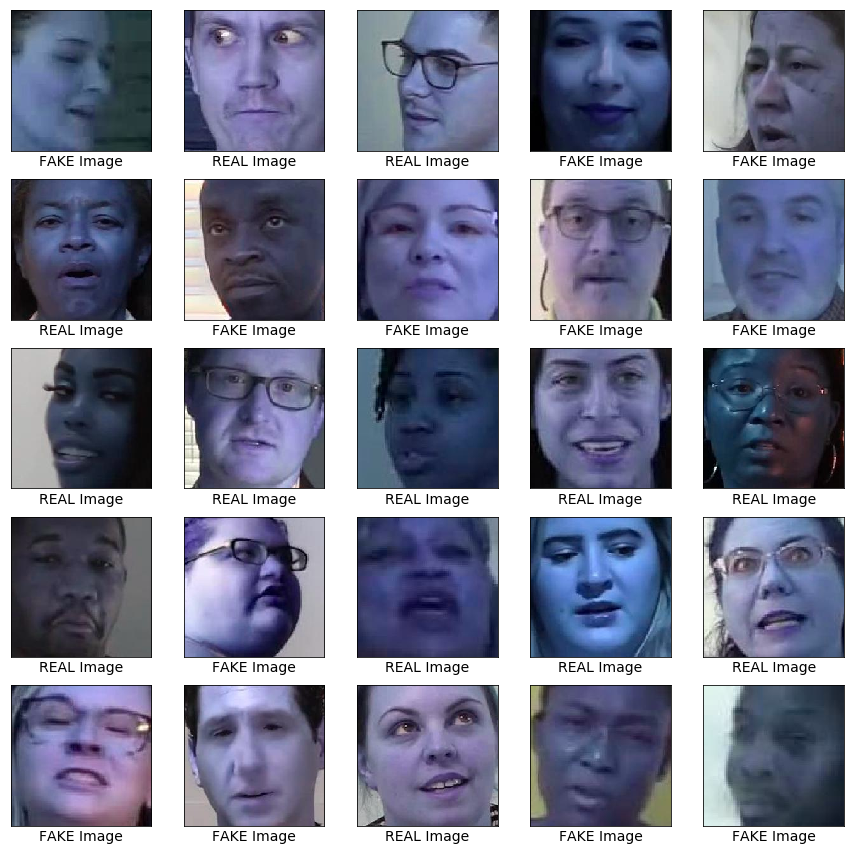

In [17]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

## Modelling

Before jumping to use pretrained model lets develop some base line model to test how our pretrained model outperforms.

### Custom CNN Architecture

In [18]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [19]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [20]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [21]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [22]:
history = model.fit(X_train, y_train, epochs=80,batch_size=32)

Train on 21060 samples
Epoch 1/80
21060/21060 [==============================] - 68s 3ms/sample - loss: 82.5672 - accuracy: 0.5073
Epoch 2/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.7252 - accuracy: 0.5846
Epoch 3/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.6188 - accuracy: 0.6620
Epoch 4/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.4520 - accuracy: 0.7852
Epoch 5/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.2562 - accuracy: 0.8927
Epoch 6/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.1489 - accuracy: 0.9491
Epoch 7/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.1151 - accuracy: 0.9630
Epoch 8/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.1088 - accuracy: 0.9691
Epoch 9/80
21060/21060 [==============================] - 63s 3ms/sample - loss: 0.1156 - accuracy: 0.9616
Epoch 10/80
2

In [23]:
# Assuming 'model' is your Keras model
model.save('my_model.h5')


In [24]:
score = model.evaluate(X_test, y_test)

2600/2600 [==============================] - 3s 991us/sample - loss: 0.8990 - accuracy: 0.5027


In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have predictions (y_pred) from your model
y_pred = model.predict(X_test)

In [26]:
# Assuming y_pred is a probability score, you may need to convert it to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

In [27]:
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5026923076923077


In [28]:
f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {f1}')

F1 Score: 0.012223071046600458


In [29]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[1299    1]
 [1292    8]]


In [30]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


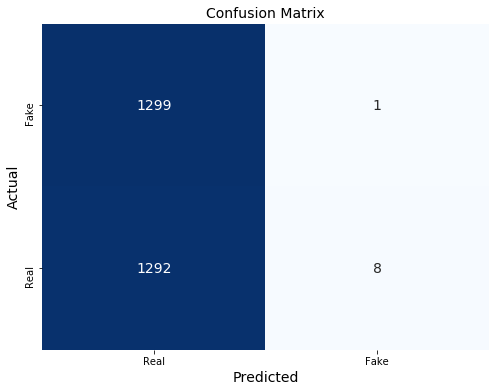

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_binary are defined

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Real', 'Fake'],
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


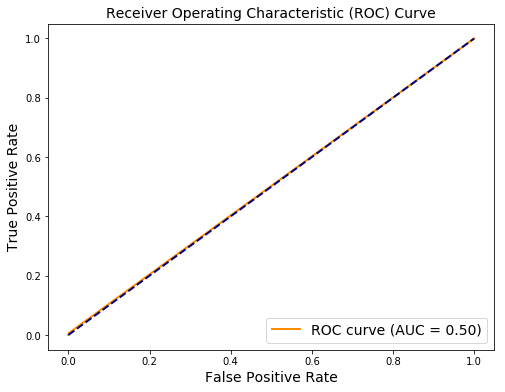

In [32]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [33]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred are defined
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Print TPR and FPR values
for i, (fpr_value, tpr_value) in enumerate(zip(fpr, tpr)):
    print(f'Threshold: {thresholds[i]:.4f}, FPR: {fpr_value:.4f}, TPR: {tpr_value:.4f}')


Threshold: 2.0000, FPR: 0.0000, TPR: 0.0000
Threshold: 1.0000, FPR: 0.0008, TPR: 0.0062
Threshold: 0.4988, FPR: 0.9992, TPR: 0.9992
Threshold: 0.0000, FPR: 1.0000, TPR: 1.0000


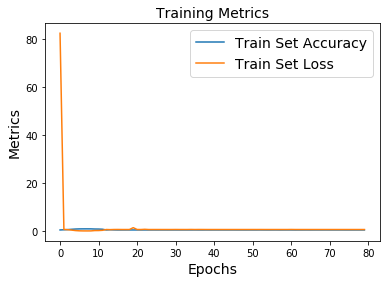

In [34]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and stored its history in 'history'

# Plot model performance
acc = history.history['accuracy']
loss = history.history['loss']

# Check if validation data was used during training
if 'val_accuracy' in history.history:
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()
else:
    # If validation data wasn't used, plot only training metrics
    plt.plot(acc, label='Train Set Accuracy')
    plt.plot(loss, label='Train Set Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Training Metrics')
    plt.show()



A baseline score of 50.06% is good to go let's finetune some pretrained model

# Pretrained Models for Transfer Learning

Here i used Xception model for fine-tuning feel free to try the performance of other pretrained models.

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [35]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [36]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all with values ranging from -1 to 1:

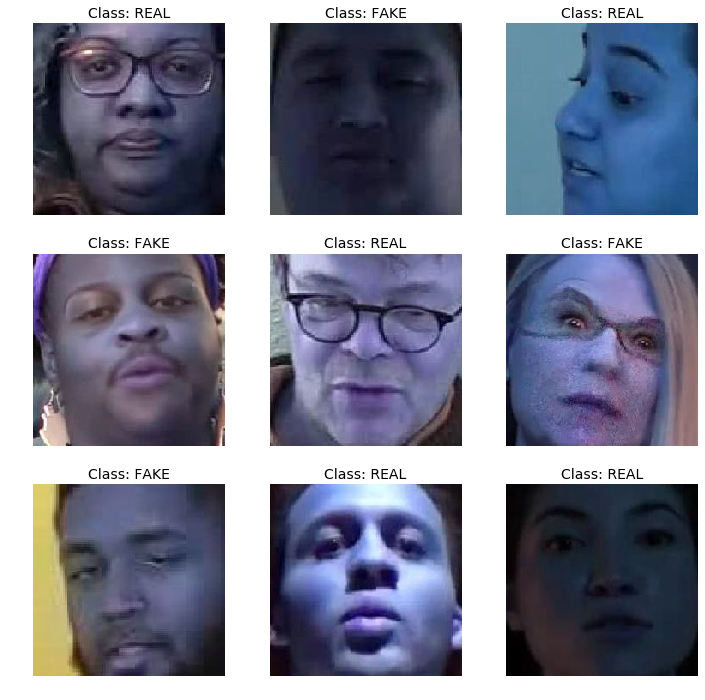

In [37]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [38]:
import tensorflow as tf
print(tf.__version__)


2.1.0-rc0


In [39]:
pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /opt/conda/lib/python3.6/site-packages (2.1.0rc0)
Note: you may need to restart the kernel to use updated packages.


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example usage:
# data_augmentation.flow(x_train, y_train, batch_size=batch_size)


Try running the following cell multiple times to see different random data augmentations:

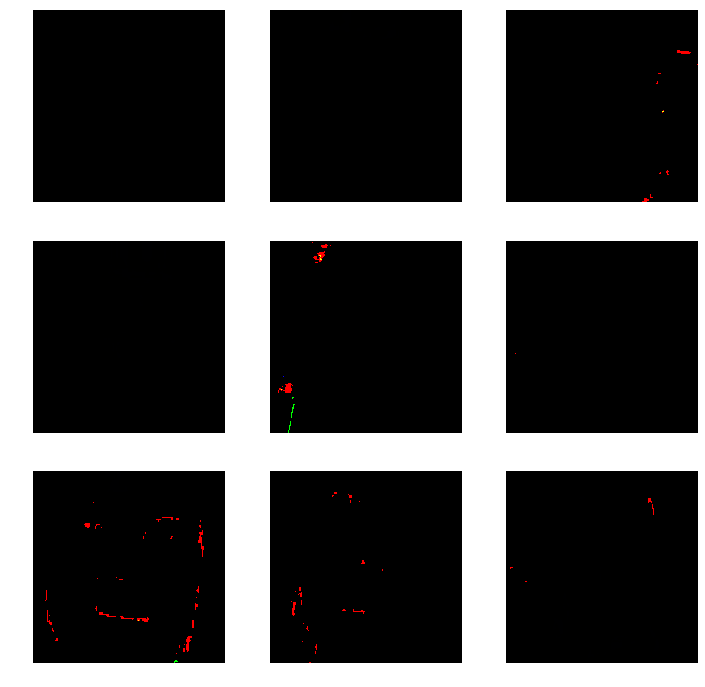

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you've defined data_augmentation using ImageDataGenerator

# Convert BatchDataset to numpy arrays
valid_data = []
valid_labels = []
for X_batch, y_batch in valid_set:
    valid_data.append(X_batch.numpy())
    valid_labels.append(y_batch.numpy())
valid_data = np.concatenate(valid_data)
valid_labels = np.concatenate(valid_labels)

# Create a generator for augmented data
data_generator = data_augmentation.flow(valid_data, valid_labels)

# Get a batch of augmented images
X_batch_augmented, y_batch = data_generator.next()

# Plot the augmented images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_batch_augmented[i].astype('uint8'))
    plt.axis('off')
plt.show()


Now let's load the pretrained model, without its top layers, and replace them with our own task

In [43]:
import tensorflow as tf

# Load the Xception model with pre-trained ImageNet weights, excluding the top fully-connected layers
base_model = tf.keras.applications.Xception(weights=None, include_top=False)

# Loop through the layers of base_model and set them to be non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers and create the final model
# (Omitted for brevity, but you can add your custom layers and create the final model here)


In [45]:
import tensorflow as tf

# Set the correct path to the Xception weights file relative to the Kaggle input directory
weights_path = "../input/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Set random seed for reproducibility
tf.random.set_seed(42)

# Load the Xception model with pre-trained ImageNet weights, excluding the top fully-connected layers
base_model = tf.keras.applications.Xception(weights=None, include_top=False)
base_model.load_weights(weights_path)

# Add a global average pooling layer to the output of the base model
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add a dense layer with sigmoid activation for binary classification
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

# Create the final model with input from Xception and output as the dense layer
model = tf.keras.Model(inputs=base_model.input, outputs=output)


OSError: Unable to open file (unable to open file: name = '../input/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

In [ ]:
model.evaluate(test_set)

In [ ]:
model.save('my_model2.h5')

Now with the finetuning the top layers of xception model the model performance jumps to 63.8% 

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

In [ ]:
model.save('xception_deepfake_image.h5')

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_set)

In [ ]:
# Evaluate on the test set
y_pred_probs = model.predict(test_set)
y_true_list = [y.numpy() for _, y in test_set_raw]  # Convert TensorFlow tensors to NumPy arrays

# Use np.hstack instead of np.concatenate
y_true = np.hstack(y_true_list)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred_probs > 0.5).astype(int)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Assuming you have y_true and y_pred_binary from your previous code

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The model accuracy finally reaches to 81.9%

Lets try to interpret the trained model on how it finds a image FAKE

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

# Deep Fake Video Classification

## Importing required libraries

In [ ]:
!pip install -U --upgrade tensorflow

In [ ]:
!pip install tensorflow-docs

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
#from imutils import paths
from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Data Visualisation

In [ ]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

In [ ]:
train_sample_metadata = pd.read_json('../input/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [ ]:
train_sample_metadata.shape

Let's visualize now the data.

We select first a list of fake videos.

### Few fake videos

In [ ]:
fake_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].sample(3).index)
fake_train_sample_video

In [ ]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv2.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

In [ ]:
for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

Let's try now the same for few of the images that are real.

### Few Real Videos

In [ ]:
real_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(3).index)
real_train_sample_video

In [ ]:
for video_file in real_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

### Videos with same original

Let's look now to set of samples with the same original.

In [ ]:
train_sample_metadata['original'].value_counts()[0:5]

We pick one of the originals with largest number of samples.

We also modify our visualization function to work with multiple images.

In [ ]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv2.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')


In [ ]:
same_original_fake_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.original=='atvmxvwyns.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

### Test video files

Let's also look to few of the test data files.

In [ ]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])

In [ ]:
test_videos.head()

Let's visualize now one of the videos.

In [ ]:
display_image_from_video(os.path.join(DATA_FOLDER, TEST_FOLDER, test_videos.iloc[2].video))

### Play video files

Let's look to few fake videos.

In [ ]:
fake_videos = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].index)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_FOLDER, subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

play_video(fake_videos[10])

From visual inspection of these fakes videos, in some cases is very easy to spot the anomalies created when engineering the deep fake, in some cases is more difficult.

## Modelling

### A CNN-RNN Architecture

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

 In this example we will do the following:

* Capture the frames of a video.
* Extract frames from the videos until a maximum frame count is reached.
* In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

We can use a pre-trained network to extract meaningful features from the extracted frames. The Keras Applications module provides a number of state-of-the-art models pre-trained on the ImageNet-1k dataset. We will be using the InceptionV3 model for this purpose.

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels == 'FAKE').astype(int)


    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

Since we don't have test labels we split the training data to find its performance in unseen data

In [ ]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(train_sample_metadata,test_size=0.1,random_state=42,stratify=train_sample_metadata['label'])

print(Train_set.shape, Test_set.shape )

In [ ]:
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

# Assuming train_data is a tuple with two elements: (frame_features, frame_masks)
frame_features_shape = train_data[0].shape if train_data and len(train_data) > 0 else None
frame_masks_shape = train_data[1].shape if train_data and len(train_data) > 1 else None

print(f"Frame features in train set: {frame_features_shape}")
print(f"Frame masks in train set: {frame_masks_shape}")


## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [ ]:
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.GRU(16, return_sequences=True)(
    frame_features_input, mask=mask_input
)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([frame_features_input, mask_input], output)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

In [ ]:
pip install --upgrade tensorflow


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only=True, save_best_only=True)
history = model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([test_data[0], test_data[1]],test_labels),
        callbacks=[checkpoint],
        epochs=EPOCHS,
        batch_size=8
    )

### Inference

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
    

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = input("Enter the path of the video: ")
print(f"Test video path: {test_video}")

if(sequence_prediction(test_video)>=0.5):
    print(f'The predicted class of the video is FAKE')
else:
    print(f'The predicted class of the video is REAL')

play_video(test_video,TEST_FOLDER)

In [ ]:
import os
import numpy as np
import imageio
from tensorflow.keras.models import load_model

# Assuming you have defined MAX_SEQ_LENGTH, NUM_FEATURES, DATA_FOLDER, TEST_FOLDER, and feature_extractor

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER, path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]

def visualize_frames_with_predictions(video_path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER, video_path))

    for i, frame in enumerate(frames):
        frame_features, frame_mask = prepare_single_video(np.array([frame]))
        prediction = sequence_prediction(video_path)

        # Print or save the individual frame along with its prediction
        print(f"Frame {i}: {'FAKE' if prediction >= 0.5 else 'REAL'}")
        plt.imshow(frame)  # Assuming you have matplotlib for visualization
        plt.show()

test_video = input("Enter the path of the video: ")
print(f"Test video path: {test_video}")

# Visualize frames with predictions
visualize_frames_with_predictions(test_video)
